<a href="https://www.kaggle.com/code/rayxxv/credit-card-fraud?scriptVersionId=112896137" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Anomaly Detection Nummerical 
Kelompok 7
Brayen Novendra 11191016
Achsani Taqwim 11191002
M Asfian 11191048


In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")



In [29]:
df = pd.read_csv("/kaggle/input/creditcard/creditcardfraud.csv")
df.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,0.510600,0.252484,0.680908,0.371591,0.635591,0.446084,0.434392,0.737173,0.655066,0.594863,0.582942,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0.005824,0
1,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.786298,0.453981,0.505267,0.381188,0.744342,0.486190,0.641219,0.383840,0.464105,0.727794,0.640681,0.551930,0.579530,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423,0.000105,0
2,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,0.513018,0.322422,0.706683,0.503854,0.640473,0.511697,0.357443,0.763381,0.644945,0.386683,0.585855,0.565477,0.546030,0.678939,0.289354,0.559515,0.402727,0.415489,0.311911,0.014739,0
3,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,0.507585,0.271817,0.710910,0.487635,0.636372,0.289124,0.415653,0.711253,0.788492,0.467058,0.578050,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371,0.004807,0
4,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,0.524303,0.236355,0.724477,0.552509,0.608406,0.349419,0.434995,0.724243,0.650665,0.626060,0.584615,0.561327,0.547271,0.663392,0.401270,0.566343,0.507497,0.420561,0.317490,0.002724,0


In [30]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000
mean,0.958294,0.767258,0.837414,0.251930,0.765716,0.263020,0.265356,0.785385,0.462780,0.508722,0.285286,0.704193,0.448331,0.646053,0.336327,0.449352,0.731130,0.653292,0.563315,0.580265,0.561480,0.510031,0.665434,0.382234,0.577907,0.425448,0.416511,0.313124,0.003439,0.001727
std,0.033276,0.017424,0.026275,0.062764,0.009292,0.013395,0.007537,0.012812,0.037846,0.022528,0.060698,0.037660,0.077041,0.032231,0.068426,0.027866,0.024678,0.057647,0.063570,0.008208,0.011841,0.033854,0.009274,0.081611,0.029261,0.078771,0.007450,0.006698,0.009736,0.041527
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.942658,0.760943,0.821985,0.214311,0.761061,0.255295,0.261980,0.783148,0.440626,0.497644,0.239943,0.688906,0.398130,0.631744,0.292753,0.434468,0.717074,0.618983,0.527682,0.578011,0.557798,0.484730,0.663030,0.334454,0.560105,0.372036,0.415203,0.312049,0.000218,0.000000
50%,0.958601,0.767949,0.840530,0.251050,0.765351,0.260263,0.265600,0.785625,0.461008,0.506800,0.283338,0.709471,0.447281,0.647755,0.339921,0.451464,0.729221,0.653042,0.563607,0.579600,0.561005,0.510347,0.665267,0.387756,0.578838,0.416932,0.416536,0.313352,0.000856,0.000000
75%,0.980645,0.775739,0.855213,0.284882,0.769836,0.267027,0.268831,0.788897,0.483350,0.518114,0.329266,0.727494,0.499613,0.662635,0.384831,0.465994,0.742743,0.687736,0.599155,0.581682,0.564484,0.534688,0.667626,0.441460,0.597593,0.464807,0.418191,0.314712,0.003004,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
# Good No Null Values!
df.isnull().sum().max()

0

In [33]:
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [35]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


**Note:**  Perhatikan betapa tidak seimbangnya kumpulan data asli Sebagian besar transaksi adalah non-penipuan. Jika menggunakan data ini sebagai dasar untuk model dan analisis prediktif, mungkin mendapatkan banyak kesalahan, dan algoritme mungkin akan terlalu cocok karena akan "menganggap" bahwa sebagian besar transaksi bukanlah penipuan. Tapi tentu kita tidak ingin model berasumsi seperti itu, yang mana harusnya model mendeteksi pola yang memberikan tanda-tanda penipuan!

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

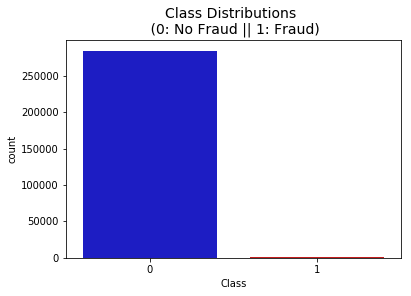

In [36]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

**Distributions:** : Dengan melihat distribusi kita dapat mengetahui seberapa tidak seimbang fitur-fitur ini, kita juga dapat melihat distribusi lebih lanjut dari fitur-fitur lainnya.

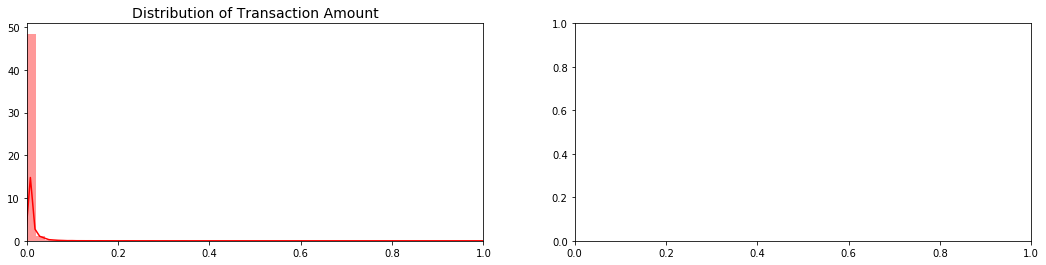

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])




plt.show()

# **Penskalaan dan Distribusi**

Dalam fase kernel kita ini, pertama-tama kita akan menskalakan kolom yang terdiri dari Amount . Jumlah harus diskalakan seperti kolom lainnya. Di sisi lain, juga perlu membuat sub sampel kerangka data agar memiliki jumlah kasus Penipuan dan Non-Penipuan yang sama, membantu algoritme kami lebih memahami pola yang menentukan apakah suatu transaksi merupakan penipuan atau bukan.

**Apa itu sub-Sampel?**

Dalam skenario ini, subsampel akan menjadi kerangka data dengan rasio transaksi penipuan dan non-penipuan 50/50. Artinya sub-sampel akan memiliki jumlah transaksi penipuan dan non penipuan yang sama.

**Mengapa kita membuat sub-Sampel?**
Di awal notebook ini terlihat bahwa kerangka data aslinya sangat tidak seimbang! Menggunakan kerangka data asli akan menyebabkan masalah berikut:

* **Overfitting**: Model klasifikasi kami akan mengasumsikan bahwa dalam banyak kasus tidak ada penipuan! Yang kami inginkan untuk model kami adalah memastikan kapan penipuan terjadi.
* **Korelasi yang Salah**: Meskipun kami tidak tahu kepanjangan dari fitur "V", akan berguna untuk memahami bagaimana masing-masing fitur ini memengaruhi hasil (Penipuan atau Tanpa Penipuan) dengan memiliki kerangka data yang tidak seimbang yang tidak dapat kami lihat korelasi yang benar antara kelas dan fitur.

**Ringkasan:**
* Jumlah yang diskalakan dan waktu yang diskalakan adalah kolom dengan nilai yang diskalakan.
* Ada 492 kasus penipuan di dataset kami sehingga kami bisa mendapatkan 492 kasus non-penipuan secara acak untuk membuat sub kerangka data baru kami.
* Kami menggabungkan 492 kasus penipuan dan bukan penipuan, membuat sub-sampel baru.

In [38]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))

df.drop('Amount', axis=1, inplace=True)

In [39]:
scaled_amount = df['scaled_amount']

df.drop('scaled_amount', axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)

# Amount and Time are Scaled!

df.head()

,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783522,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,0.510600,0.252484,0.680908,0.371591,0.635591,0.446084,0.434392,0.737173,0.655066,0.594863,0.582942,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0
1,-0.269610,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.786298,0.453981,0.505267,0.381188,0.744342,0.486190,0.641219,0.383840,0.464105,0.727794,0.640681,0.551930,0.579530,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423,0
2,4.984024,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,0.513018,0.322422,0.706683,0.503854,0.640473,0.511697,0.357443,0.763381,0.644945,0.386683,0.585855,0.565477,0.546030,0.678939,0.289354,0.559515,0.402727,0.415489,0.311911,0
3,1.418417,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,0.507585,0.271817,0.710910,0.487635,0.636372,0.289124,0.415653,0.711253,0.788492,0.467058,0.578050,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371,0
4,0.670616,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,0.524303,0.236355,0.724477,0.552509,0.608406,0.349419,0.434995,0.724243,0.650665,0.626060,0.584615,0.561327,0.547271,0.663392,0.401270,0.566343,0.507497,0.420561,0.317490,0


# **Memisahkan Data (DataFrame Asli)**
Sebelum melanjutkan dengan teknik Random UnderSampling kita harus memisahkan kerangka data asli. Mengapa? untuk tujuan pengujian, ingat meskipun kami memisahkan data saat menerapkan teknik Random UnderSampling atau OverSampling, kami ingin menguji model kami pada set pengujian asli, bukan pada set pengujian yang dibuat oleh salah satu dari teknik ini. Tujuan utamanya adalah untuk menyesuaikan model baik dengan kerangka data yang undersample dan oversample (agar model kami dapat mendeteksi pola), dan mengujinya pada set pengujian asli.

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


**Pengambilan Sampel Bawah Acak:**


Dalam fase proyek ini akan diimplementasikan "Random Under Sampling" yang pada dasarnya terdiri dari menghapus data untuk mendapatkan dataset yang lebih seimbang dan dengan demikian menghindari model kami untuk overfitting.

Langkah:
* Hal pertama yang harus dilakukan adalah menentukan seberapa tidak seimbang kelas kita (gunakan "value_counts()" pada kolom kelas untuk menentukan jumlah setiap label)
* Setelah berapa banyak contoh yang dianggap sebagai transaksi penipuan (Penipuan = "1") , harus membawa transaksi non-penipuan ke jumlah yang sama dengan transaksi penipuan (dengan asumsi kami menginginkan rasio 50/50), ini akan setara dengan 492 kasus fraud dan 492 kasus transaksi non-fraud.
* Setelah menerapkan teknik ini, dimiliki sub-sampel kerangka data dengan rasio 50/50 terkait dengan kelas yang ada. Kemudian langkah selanjutnya yang akan diterapkan adalah mengocok data untuk melihat apakah model kita dapat mempertahankan akurasi tertentu setiap kali menjalankan skrip ini.

Catatan: Masalah utama dengan "Random Under-Sampling" adalah bahwa dijalankan risiko bahwa model klasifikasi kami tidak akan bekerja seakurat yang diinginkan karena ada banyak kehilangan informasi (menyebabkan 492 transaksi non-penipuan dari 284.315 transaksi non-penipuan)

In [41]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
246302,0.049901,0.880153,0.793491,0.838443,0.113406,0.747980,0.302296,0.214342,0.622439,0.364451,0.469597,0.247072,0.732992,0.373584,0.696924,0.247354,0.502563,0.750116,0.773904,0.440647,0.601469,0.511066,0.579557,0.681979,0.406559,0.583533,0.403313,0.416268,0.315975,0
142557,4.644050,0.933985,0.758791,0.856879,0.269208,0.763823,0.262466,0.273435,0.787485,0.443941,0.493960,0.361082,0.705085,0.330541,0.670506,0.348775,0.460420,0.714673,0.668149,0.474261,0.587018,0.566728,0.510684,0.677982,0.397725,0.586684,0.324265,0.414290,0.313846,1
256433,-0.181655,0.958080,0.774989,0.842222,0.227317,0.768317,0.251153,0.271087,0.783609,0.464888,0.500651,0.223708,0.695982,0.396544,0.654521,0.311928,0.447308,0.720505,0.607653,0.556789,0.579706,0.557306,0.480648,0.666999,0.384903,0.549381,0.448293,0.420910,0.315108,0
77387,5.899479,0.918614,0.790739,0.778853,0.348503,0.741695,0.266205,0.254786,0.800930,0.394571,0.390553,0.394537,0.533066,0.506219,0.434752,0.326692,0.336035,0.517036,0.468080,0.528131,0.583183,0.574143,0.523905,0.670016,0.301598,0.571067,0.345242,0.429461,0.317324,1
623,7.084904,0.906588,0.733944,0.856275,0.353384,0.774870,0.252314,0.267339,0.784658,0.453446,0.491372,0.260633,0.685229,0.500697,0.589161,0.485889,0.470557,0.748555,0.771954,0.585442,0.602650,0.572146,0.530346,0.685868,0.342644,0.593612,0.401704,0.411845,0.313850,1


# **Sama Mendistribusikan dan Berkorelasi:**
Sekarang setelah kerangka data kami seimbang dengan benar, kami dapat melangkah lebih jauh dengan analisis dan pemrosesan awal data kami.

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


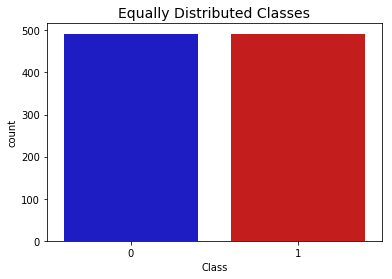

In [42]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))



sns.countplot('Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

# Matriks Korelasi
Matriks korelasi adalah inti dari pemahaman data. kami ingin mengetahui apakah ada fitur yang sangat memengaruhi apakah transaksi tertentu merupakan penipuan. Namun, penting untuk menggunakan kerangka data (subsampel) yang benar agar dapat melihat fitur mana yang memiliki korelasi positif atau negatif yang tinggi terkait dengan transaksi penipuan.

**Ringkasan dan Penjelasan:**

* Korelasi Positif: semuanya berkorelasi positif. Perhatikan bagaimana semakin tinggi nilai-nilai ini, semakin besar kemungkinan hasil akhirnya adalah transaksi penipuan.
* BoxPlots: Kami akan menggunakan boxplots untuk lebih memahami distribusi fitur ini dalam transaksi penipuan dan non penipuan

**Catatan:** Kami harus memastikan bahwa kami menggunakan subsampel dalam matriks korelasi kami atau matriks korelasi kami akan dipengaruhi oleh ketidakseimbangan yang tinggi antara kelas kami. Ini terjadi karena ketidakseimbangan kelas tinggi dalam kerangka data asli.

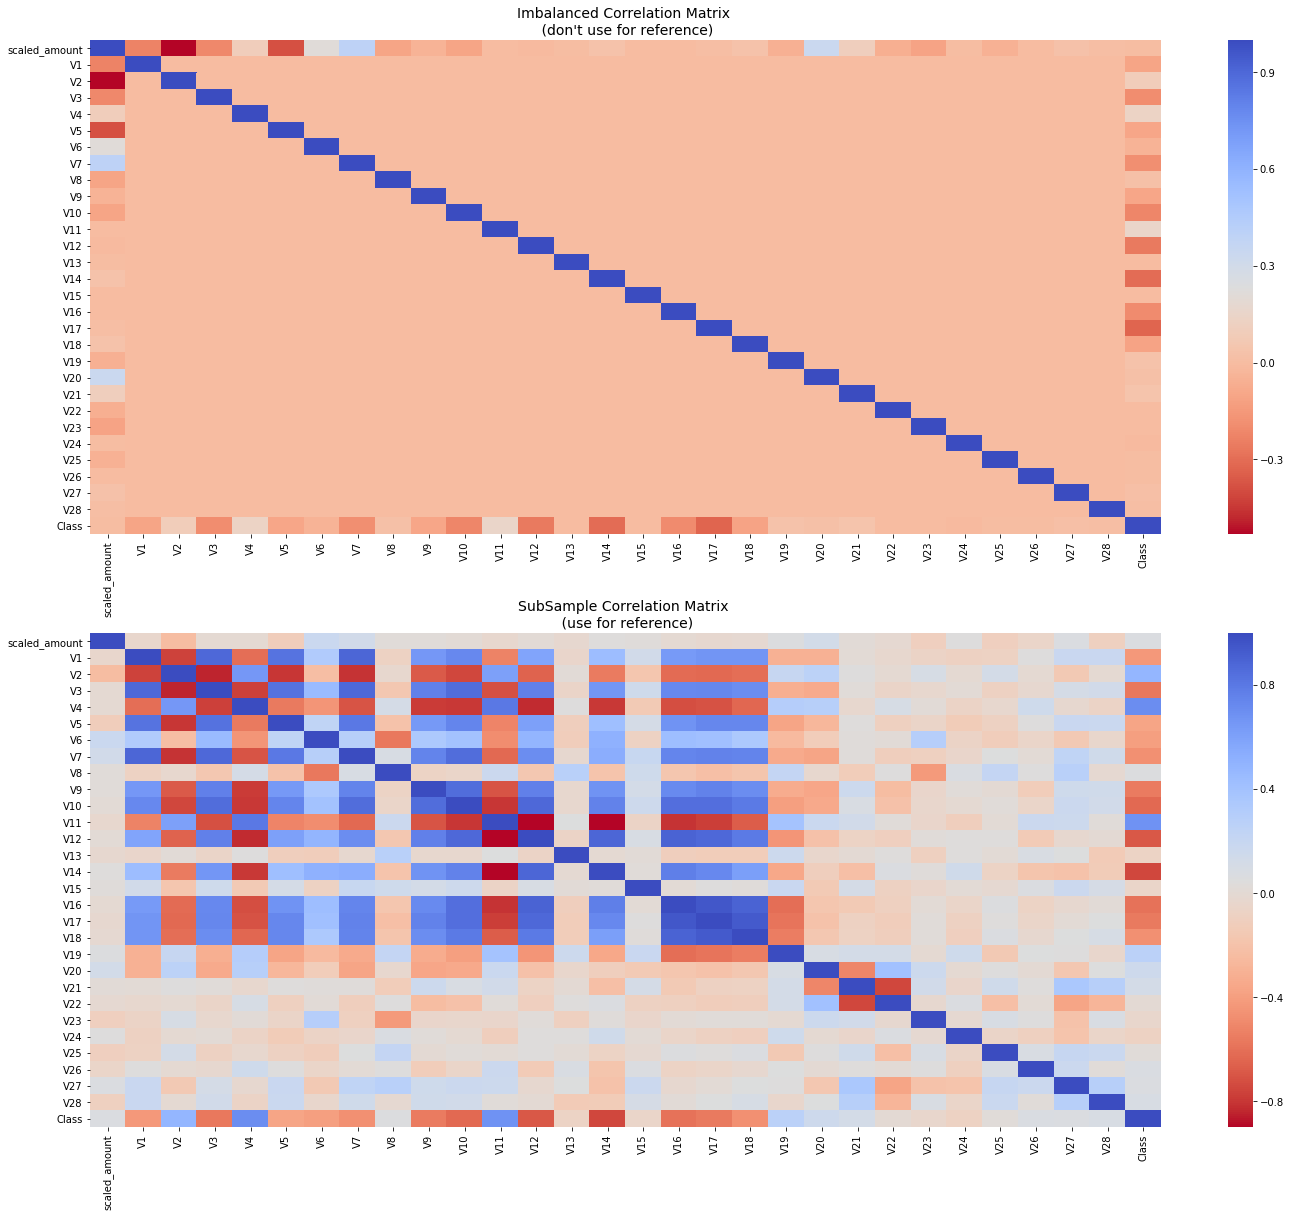

In [43]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

# Deteksi Anomali:


Tujuan utama di bagian ini adalah untuk menghapus "extreme outlier" dari fitur yang memiliki korelasi tinggi dengan kelas. Ini akan berdampak positif pada keakuratan model .


**Metode Rentang Interkuartil:**
* **Rentang Interkuartil (IQR):** Kami menghitung ini dengan selisih antara persentil ke-75 dan persentil ke-25. Tujuannya adalah membuat ambang melebihi persentil ke-75 dan ke-25 sehingga jika beberapa instans melewati ambang ini, instans akan dihapus.
* **Boxplots:** Selain dengan mudah melihat persentil ke-25 dan ke-75 (kedua ujung kotak), juga mudah untuk melihat outlier ekstrem (titik di luar ekstrem bawah dan ekstrem tinggi).

# Pengorbanan Penghapusan Outlier:
Kita harus berhati-hati tentang seberapa diinginkan ambang batas untuk menghilangkan outlier. Menentukan ambang batas dengan mengalikan angka (mis: 1,5) dengan (Jangkauan Interkuartil). Semakin tinggi ambang ini, semakin sedikit outlier yang akan terdeteksi (dikalikan dengan angka yang lebih tinggi, mis: 3), dan semakin rendah ambang ini, semakin banyak outlier yang akan dideteksi.


**Pengorbanan:** Semakin rendah ambang batas, semakin banyak outlier yang akan dihapus, namun ingin lebih fokus pada "outlier ekstrem" daripada hanya outlier. Mengapa? karena mungkin menghadapi risiko kehilangan informasi yang akan menyebabkan model dimiliki akurasi yang lebih rendah. 

**Ringkasan:**
* **Visualisasikan Distribusi**: Pertama-tama mulai dengan memvisualisasikan distribusi fitur yang akan kita gunakan untuk menghilangkan beberapa outlier. V14 merupakan satu-satunya fitur yang memiliki distribusi Gaussian dibandingkan dengan fitur V12 dan V10.
* **Menentukan ambang batas**: Setelah kita memutuskan angka mana yang akan digunakan untuk mengalikan dengan iqr (semakin banyak outlier yang lebih rendah dihilangkan), akan dilanjutkan dalam menentukan ambang atas dan bawah dengan mensubstratkan q25 - ambang batas (ambang batas ekstrim bawah) dan menambahkan q75 + ambang batas (ambang batas ekstrim atas).
* **Penjatuhan Bersyarat**: Terakhir, membuat penjatuhan bersyarat yang menyatakan bahwa jika "ambang batas" terlampaui di kedua ekstrem, instance akan dihapus.
* **Representasi Boxplot**: Visualisasikan melalui boxplot bahwa jumlah "outlier ekstrim" telah dikurangi menjadi jumlah yang cukup besar.

**Catatan**: Setelah menerapkan pengurangan outlier, akurasi meningkat lebih dari 3%! Beberapa outlier dapat mendistorsi keakuratan model, tetapi, kita harus menghindari kehilangan informasi dalam jumlah yang sangat besar atau model kita berisiko mengalami underfitting.


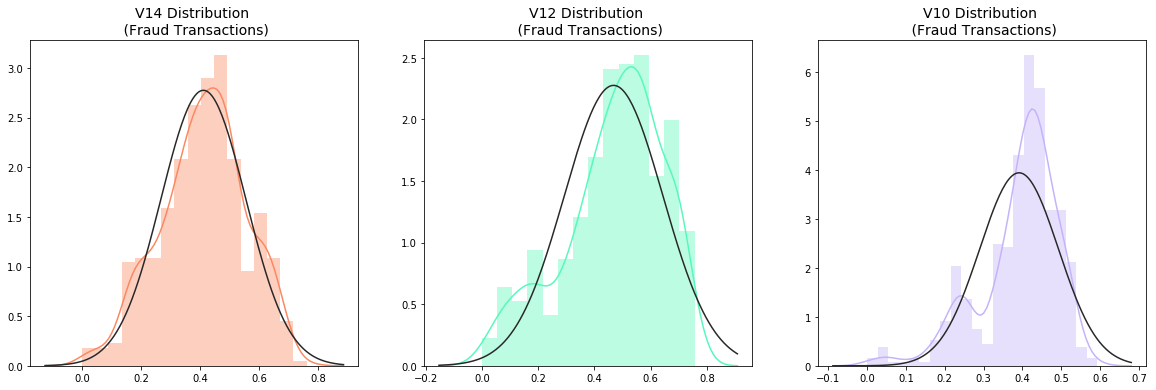

In [46]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [49]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: 0.3573835 | Quartile 75: 0.5112582499999999
iqr: 0.1538747499999999
Cut Off: 0.23081212499999984
V14 Lower: 0.12657137500000018
V14 Upper: 0.7420703749999997
Feature V14 Outliers for Fraud Cases: 0
V10 outliers:[]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: 0.1879013749999997
V12 Upper: 0.8596343750000003
V12 outliers: [0.158866, 0.16616199999999998, 0.16537000000000002, 0.135291]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 895
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: 0.2830004999999999
V10 Upper: 0.5728305000000001
V10 outliers: [0.27038, 0.26800999999999997, 0.276969, 0.575862, 0.268934]
Feature V10 Outliers for Fraud Cases: 5
Number of Instances

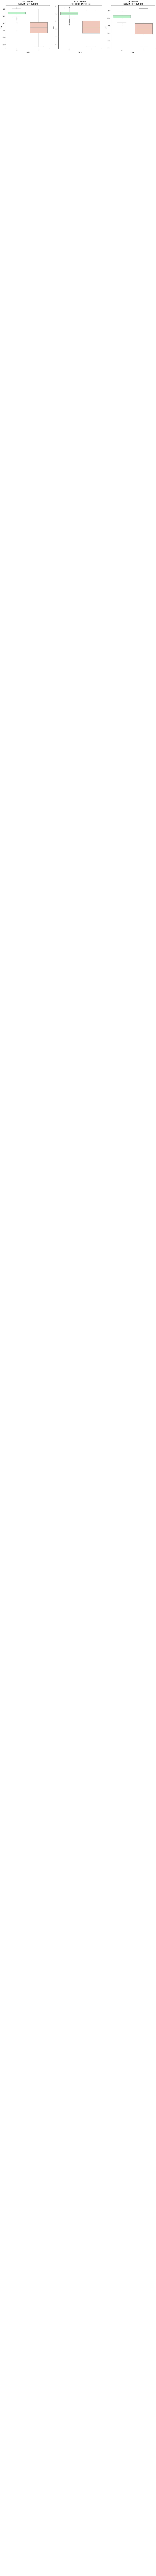

In [50]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

# Pengurangan Dimensi dan Pengelompokan:

**Memahami t-SNE:**
Untuk memahami algoritma ini, Anda harus memahami istilah-istilah berikut:
* Jarak Euclidean
* Probabilitas Bersyarat
* Plot Normal dan Distribusi-T

**Catatan:** Jika Anda ingin melihat video instruktif sederhana di StatQuest: t-SNE, Dijelaskan dengan Jelas oleh Joshua Starmer

**Ringkasan:**
* Algoritme t-SNE dapat secara akurat mengelompokkan kasus penipuan dan non-penipuan dalam kumpulan data kami.
* Meskipun subsampelnya cukup kecil, algoritme t-SNE mampu mendeteksi cluster dengan cukup akurat di setiap skenario (saya mengocok dataset sebelum menjalankan t-SNE)
* Ini memberi kami indikasi bahwa model prediktif lebih lanjut akan bekerja cukup baik dalam memisahkan kasus penipuan dari kasus non-penipuan.

In [51]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 5.7 s
PCA took 0.012 s
Truncated SVD took 0.0056 s


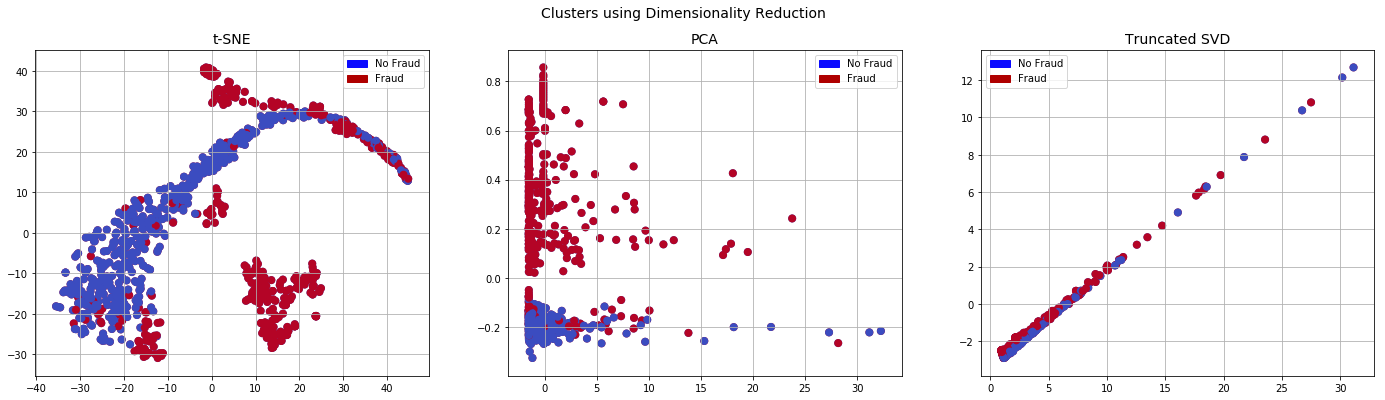

In [52]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

# Pengklasifikasi (UnderSampling):
Pada bagian ini kita akan melatih empat jenis pengklasifikasi dan memutuskan pengklasifikasi mana yang lebih efektif dalam mendeteksi transaksi penipuan. Sebelum kita harus membagi data kita menjadi set pelatihan dan pengujian dan memisahkan fitur dari label.

**Ringkasan:**
* Pengklasifikasi Regresi Logistik lebih akurat daripada tiga pengklasifikasi lainnya dalam banyak kasus. (Kami akan menganalisis Regresi Logistik lebih lanjut)
* GridSearchCV digunakan untuk menentukan paremeter yang memberikan skor prediktif terbaik untuk pengklasifikasi.
* Regresi Logistik memiliki skor Receiving Operating Characteristic (ROC) terbaik, artinya Regresi Logistik cukup akurat memisahkan transaksi penipuan dan non-penipuan.

**Kurva Pembelajaran:**
* Semakin lebar jarak antara skor pelatihan dan skor validasi silang, semakin besar kemungkinan model Anda mengalami overfitting (varians tinggi).
* Jika skornya rendah di set pelatihan dan validasi silang, ini merupakan indikasi bahwa model kami tidak sesuai (bias tinggi)
* Pengklasifikasi Regresi Logistik menunjukkan skor terbaik dalam set pelatihan dan validasi silang.

In [53]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [58]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
212837,2.515527,0.988592,0.740695,0.839160,0.198994,0.750943,0.271620,0.253226,0.789207,0.455353,0.536566,0.292217,0.713719,0.467800,0.605500,0.185855,0.432771,0.749868,0.685957,0.584582,0.579787,0.560402,0.515396,0.668016,0.477518,0.547569,0.385048,0.417412,0.313088
151807,0.161910,0.897947,0.824516,0.772747,0.548007,0.750990,0.287491,0.212061,0.655502,0.364383,0.391497,0.436378,0.472509,0.587422,0.500497,0.325111,0.390869,0.633657,0.633876,0.574919,0.620648,0.469771,0.627168,0.679600,0.309132,0.543096,0.491770,0.416936,0.316467
51231,-0.139652,0.980132,0.763723,0.856919,0.277375,0.757007,0.258337,0.260570,0.785069,0.438588,0.525494,0.248110,0.703468,0.493342,0.641372,0.422933,0.420399,0.718984,0.756673,0.455161,0.574863,0.555997,0.487026,0.666997,0.427365,0.590122,0.354761,0.417992,0.314038
144379,-0.279663,0.980283,0.769059,0.842360,0.274672,0.763569,0.255686,0.265295,0.784074,0.470238,0.507927,0.236759,0.693733,0.409259,0.659166,0.423630,0.464955,0.715084,0.634826,0.569163,0.578829,0.556635,0.467554,0.666705,0.362729,0.592118,0.446440,0.415852,0.313368
216533,1.089930,0.942921,0.764410,0.875488,0.248109,0.766414,0.287165,0.262621,0.793204,0.411902,0.513299,0.322891,0.729744,0.542737,0.634876,0.406565,0.388580,0.736645,0.739222,0.494663,0.579151,0.559852,0.517635,0.665091,0.154898,0.584567,0.373209,0.419775,0.314797
156988,-0.307306,0.970953,0.796901,0.736468,0.510616,0.769165,0.256830,0.247587,0.793717,0.398057,0.414648,0.564703,0.383533,0.503928,0.389549,0.168156,0.367982,0.576999,0.587477,0.517606,0.584555,0.566071,0.469241,0.664186,0.294453,0.603424,0.433677,0.430483,0.320914
89190,19.286304,0.867495,0.764243,0.770948,0.488517,0.714487,0.301976,0.273212,0.787550,0.359314,0.426159,0.581783,0.473665,0.451607,0.442853,0.472490,0.298439,0.438372,0.405380,0.675399,0.563632,0.565929,0.572637,0.650337,0.372618,0.559053,0.497492,0.444578,0.290478
163586,0.600969,0.974420,0.781329,0.753276,0.333274,0.758626,0.237253,0.251423,0.788184,0.431936,0.414737,0.431197,0.518561,0.355411,0.430043,0.412198,0.349831,0.581577,0.528432,0.603961,0.584786,0.566422,0.470163,0.666936,0.344303,0.579279,0.407816,0.428052,0.319530
28576,0.677437,0.978104,0.767427,0.827759,0.260824,0.770292,0.267414,0.266924,0.785359,0.448641,0.509816,0.317235,0.741001,0.528140,0.659643,0.363016,0.457922,0.707864,0.647291,0.587117,0.581341,0.561189,0.504407,0.661286,0.209824,0.614531,0.499661,0.415628,0.312959
76404,0.081493,0.980572,0.767448,0.830953,0.258496,0.765400,0.254928,0.266623,0.783327,0.472313,0.507203,0.209348,0.671967,0.347361,0.668091,0.417023,0.458595,0.717758,0.648112,0.589821,0.579008,0.559468,0.489332,0.663096,0.322437,0.610173,0.532483,0.414949,0.313008


In [60]:
# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [62]:
# Wow our scores are getting even high scores even when applying cross validation.
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 91.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 90.0 % accuracy score
Classifiers:  SVC Has a training score of 86.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 91.0 % accuracy score


In [64]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

In [65]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  93.1%
Knears Neighbors Cross Validation Score 90.43%
Support Vector Classifier Cross Validation Score 91.4%
DecisionTree Classifier Cross Validation Score 92.81%


In [66]:
# We will undersample during cross validating
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [ 56955  56956  56957 ... 284804 284805 284806] Test: [    0     1     2 ... 59427 59581 59613]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 56955  56956  56957 ... 114971 115294 115602]
Train: [     0      1      2 ... 284804 284805 284806] Test: [113919 113920 113921 ... 178754 179178 179407]
Train: [     0      1      2 ... 284804 284805 284806] Test: [170873 170874 170875 ... 227843 227991 228904]
Train: [     0      1      2 ... 227843 227991 228904] Test: [227844 227845 227846 ... 284804 284805 284806]
NearMiss Label Distribution: Counter({0: 492, 1: 492})


In [67]:
# Let's Plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

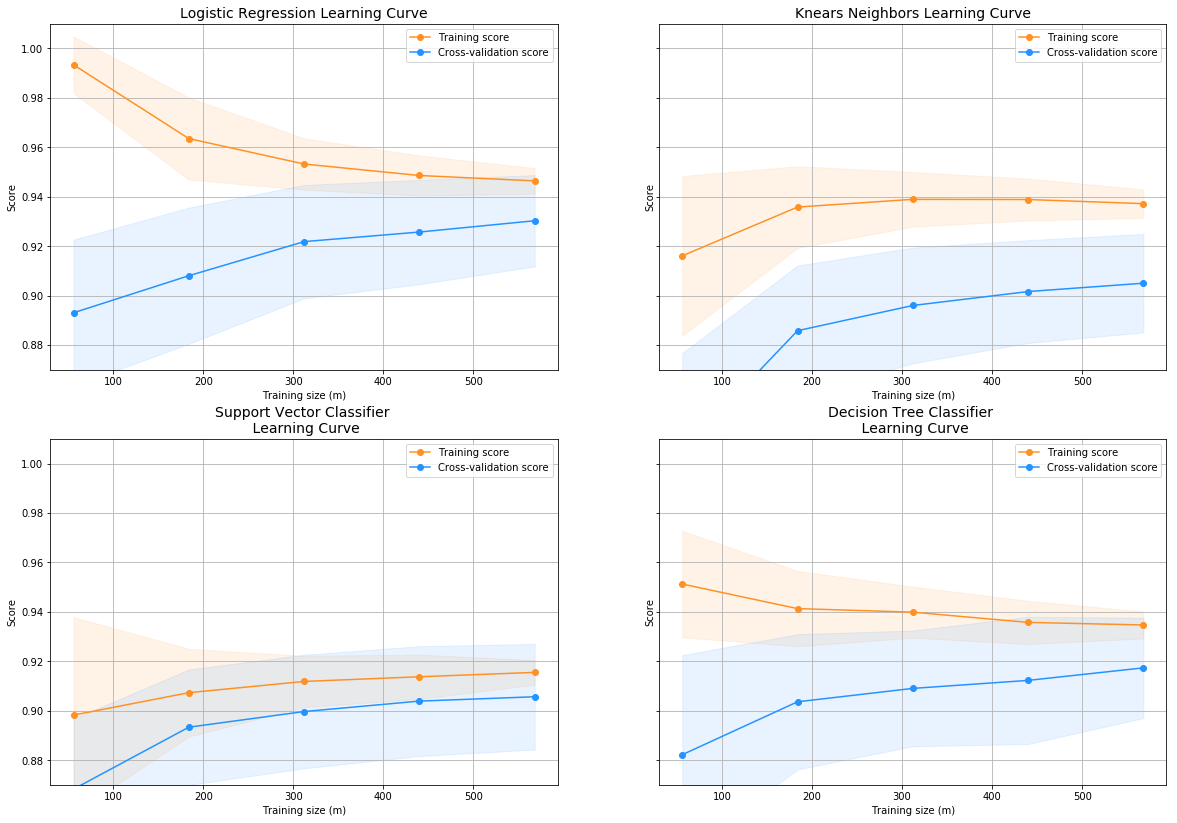

In [68]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [70]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [73]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9747144140675139
KNears Neighbors:  0.901392632524708
Support Vector Classifier:  0.9772333461686562
Decision Tree Classifier:  0.9230763059940958


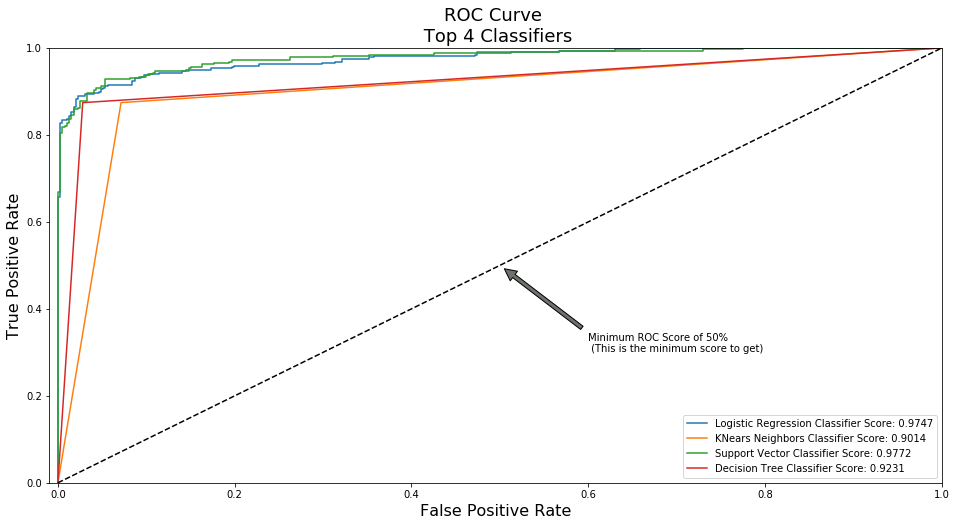

In [74]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

# Pandangan Lebih Dalam tentang Regresi Logistik:
Pada bagian ini kita akan melihat lebih dalam ke **pengklasifikasi regresi logistik**.

Ketentuan:
* **Positif Sejati**: Transaksi Penipuan yang Diklasifikasikan dengan Benar
* **Positif Palsu**: Salah Mengklasifikasikan Transaksi Penipuan
* **Benar Negatif**: Transaksi Non-Penipuan yang Diklasifikasikan dengan Benar
* **Negatif Palsu**: Salah Mengklasifikasikan Transaksi Non-Penipuan
* **Presisi**: Positif Sejati/(Positif Sejati + Positif Palsu)
* **Ingat**: Positif Sejati/(Positif Sejati + Negatif Palsu)
* Presisi seperti namanya, mengatakan seberapa tepat (seberapa yakin) model kami dalam mendeteksi transaksi penipuan sementara penarikan kembali adalah jumlah kasus penipuan yang dapat dideteksi oleh model kami.
* **Pengorbanan Presisi/Recall**: Semakin tepat (selektif) model kita, semakin sedikit kasus yang akan dideteksi. Contoh: Dengan asumsi bahwa model kami memiliki presisi 95%, Katakanlah hanya ada 5 kasus penipuan di mana modelnya 95% tepat atau lebih dari kasus penipuan. Lalu katakanlah ada 5 kasus lagi yang model kita anggap 90% sebagai kasus penipuan, jika kita menurunkan presisi, ada lebih banyak kasus yang dapat dideteksi oleh model kita.

**Ringkasan:**
* **Presisi mulai turun** antara 0,90 dan 0,92 namun demikian, skor presisi kami masih cukup tinggi dan kami masih memiliki skor penarikan turun.

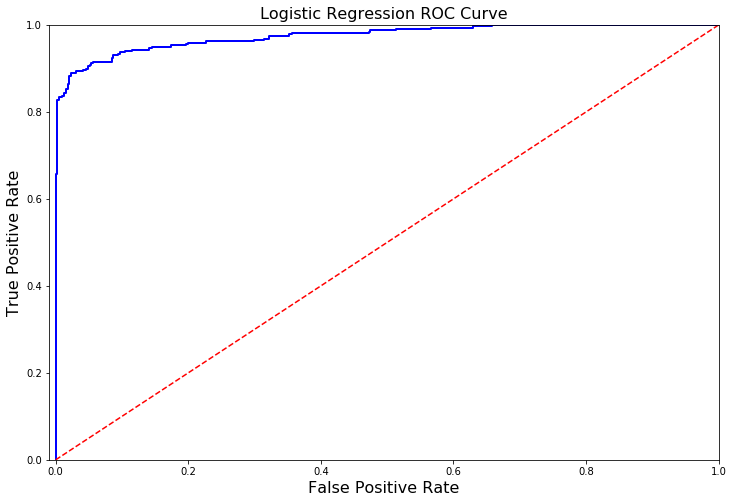

In [75]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [76]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [77]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.96
Precision Score: 0.56
F1 Score: 0.71
Accuracy Score: 0.64
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.41
Precision Score: 0.00
Recall Score: 0.54
F1 Score: 0.00
---------------------------------------------------------------------------------------------------------------------------------------


In [82]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [83]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.00


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.00')

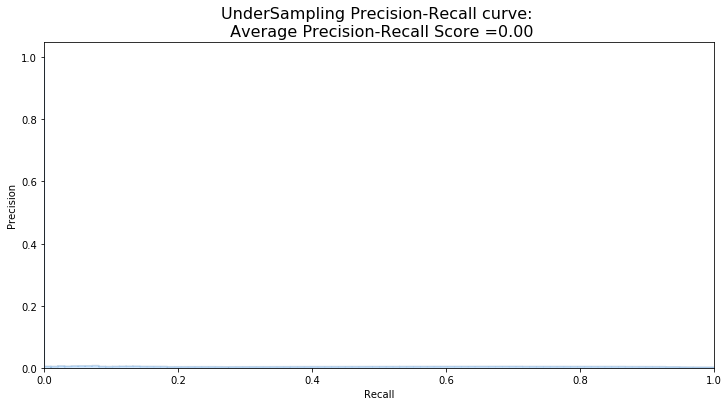

In [84]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

# Teknik SMOTE (Over-Sampling):
SMOTE singkatan dari Synthetic Minority Over-sampling Technique. Tidak seperti Random UnderSampling, SMOTE membuat poin sintetik baru agar memiliki keseimbangan kelas yang setara. Ini adalah alternatif lain untuk memecahkan "masalah ketidakseimbangan kelas".


**Memahami SMOTE:**

* **Memecahkan Ketidakseimbangan Kelas**: SMOTE menciptakan poin sintetik dari kelas minoritas untuk mencapai keseimbangan yang setara antara kelas minoritas dan mayoritas.
* **Lokasi titik sintetik**: SMOTE mengambil jarak antara tetangga terdekat dari kelas minoritas, di antara jarak ini menciptakan titik sintetik.
* **Efek Akhir**: Lebih banyak informasi disimpan karena kami tidak perlu menghapus baris apa pun tidak seperti di undersampling acak.
* **Akurasi || Pengorbanan Waktu**: Meskipun kemungkinan SMOTE akan lebih akurat daripada pengambilan sampel acak, akan membutuhkan lebih banyak waktu untuk berlatih karena tidak ada baris yang dihilangkan seperti yang dinyatakan sebelumnya.

**Kesalahan Overfitting Validasi Silang:**
# Overfitting selama Validasi Silang:
Dalam analisis contoh kecil kami, saya ingin menunjukkan kepada Anda kesalahan umum yang saya buat yang ingin saya bagikan dengan Anda semua. Sederhana saja, jika Anda ingin meremehkan atau melampaui sampel data Anda, Anda tidak boleh melakukannya sebelum melakukan validasi silang. Mengapa karena Anda akan secara langsung memengaruhi set validasi sebelum menerapkan validasi silang yang menyebabkan masalah "kebocoran data". 

In [86]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()




rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 227846 | Length of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9830455422055246
precision: 0.08726002094328374
recall: 0.8933787731256085
f1: 0.1586013215574112
---------------------------------------------------------------------------------------------------------------------------------------


In [97]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56863
       Fraud       0.09      0.87      0.17        98

    accuracy                           0.99     56961
   macro avg       0.55      0.93      0.58     56961
weighted avg       1.00      0.99      0.99     56961



In [101]:
y_score = best_est.decision_function(original_Xtest)

In [102]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.76


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.76')

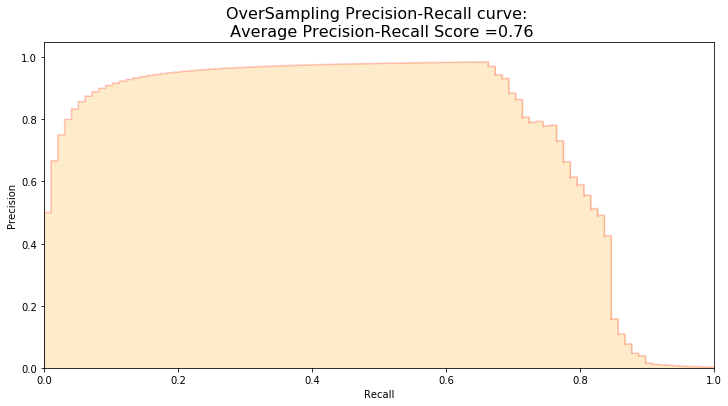

In [104]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [105]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(ratio='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)

In [106]:
# We Improve the score by 2% points approximately 
# Implement GridSearchCV and the other models.

# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :14.674900770187378 sec


**# Data Uji dengan Regresi Logistik:**

# **Matriks Kebingungan:**
**Positif/Negatif**: Jenis Kelas (label) ["Tidak", "Ya"] **Benar/Salah**: Diklasifikasikan dengan benar atau salah oleh model.


**True Negatives (Top-Left Square)**: Ini adalah jumlah klasifikasi yang **benar** dari kelas "No" (Penipuan Tidak Terdeteksi).


**False Negatives (Top-Right Square)**: Ini adalah jumlah klasifikasi yang **salah** dari kelas "No"(Penipuan Tidak Terdeteksi).


**Positif Palsu (Persegi Bawah-Kiri)**: Ini adalah jumlah klasifikasi yang **salah** dari kelas "Ya" (Penipuan Terdeteksi)


**True Positives (Persegi Bawah-Kanan)**: Ini adalah jumlah klasifikasi yang **benar** dari kelas "Ya" (Penipuan Terdeteksi).

**Ringkasan:**
* **Random UnderSampling**:mengevaluasi kinerja akhir dari model klasifikasi dalam subset undersampling acak. **Perlu diingat bahwa ini bukan data dari kerangka data asli.**
* **Model Klasifikasi**: Model yang berkinerja terbaik adalah **regresi logistik** dan **support vector classifier (SVM)**

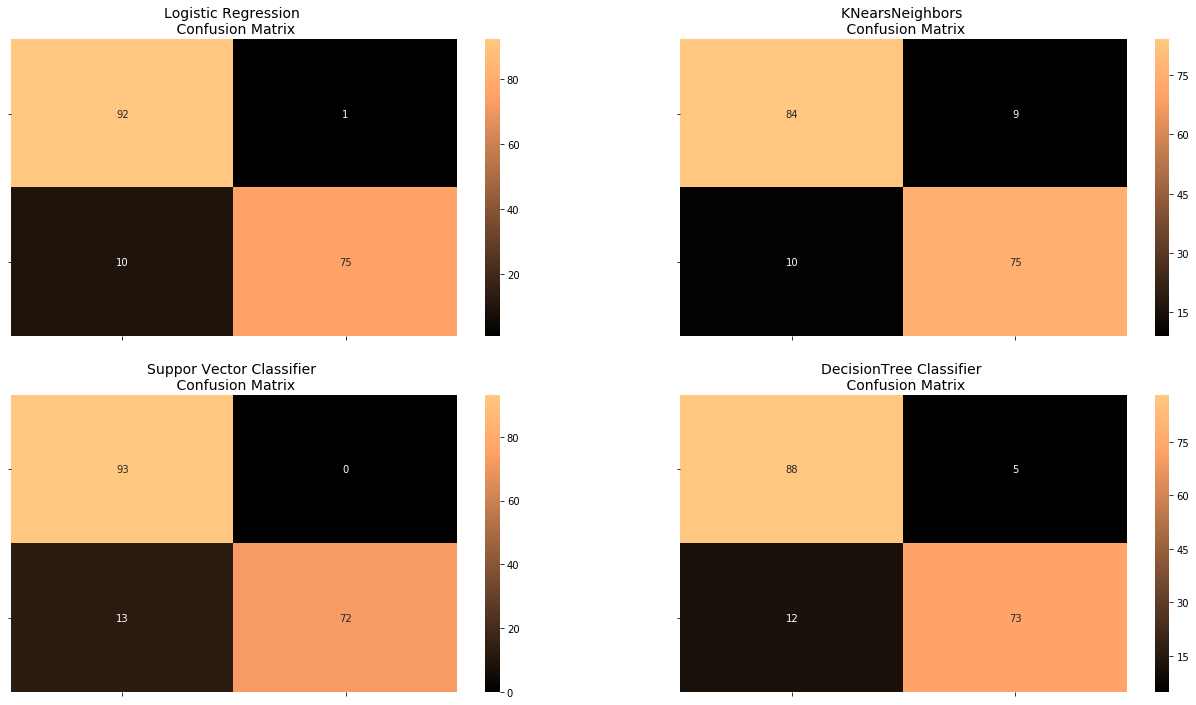

In [107]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [108]:
from sklearn.metrics import classification_report


print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94        93
           1       0.99      0.88      0.93        85

    accuracy                           0.94       178
   macro avg       0.94      0.94      0.94       178
weighted avg       0.94      0.94      0.94       178

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90        93
           1       0.89      0.88      0.89        85

    accuracy                           0.89       178
   macro avg       0.89      0.89      0.89       178
weighted avg       0.89      0.89      0.89       178

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        93
           1       1.00      0.85      0.92        85

    accuracy                           0.93       178
   macro avg       0.94      0.92      0.93       178
weighted

In [109]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)



# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Note how high is accuracy score it can be misleading! 
final_df

,Technique,Score
0,Random UnderSampling,0.938202
1,Oversampling (SMOTE),0.985323


# Pengujian Jaringan Neural Acak Data UnderSampling vs OverSampling (SMOTE):

Pada bagian ini kita akan mengimplementasikan Neural Network sederhana (dengan satu lapisan tersembunyi) untuk melihat mana dari dua model regresi logistik yang kita terapkan di (undersample atau oversample(SMOTE)) memiliki akurasi yang lebih baik untuk mendeteksi penipuan dan non-penipuan transaksi.


**Tujuan Utama :**
Mengeksplorasi bagaimana jaringan saraf sederhana kami berperilaku baik dalam kerangka data acak undersample dan oversample dan melihat apakah mereka dapat memprediksi secara akurat kasus non-penipuan dan penipuan. Mengapa tidak hanya fokus pada penipuan? Bayangkan Anda adalah pemegang kartu dan setelah Anda membeli barang, kartu Anda diblokir karena algoritme bank mengira pembelian Anda adalah penipuan. Oleh karena itu, kita tidak hanya menekankan pada pendeteksian kasus penipuan, tetapi kita juga harus menekankan pengkategorian transaksi non-penipuan dengan benar.

**Matriks Kebingungan:**
Ini sekali lagi, bagaimana matriks kebingungan bekerja:

* **Kotak Kiri Atas**: Jumlah yang diklasifikasikan dengan **benar** berdasarkan model transaksi tanpa penipuan kami.
* **Kotak Kanan Atas**: Jumlah transaksi yang **salah** diklasifikasikan sebagai kasus penipuan, tetapi label sebenarnya bukanlah penipuan .
* **Kotak Kiri Bawah**: Jumlah transaksi yang **salah** diklasifikasikan sebagai tidak ada kasus penipuan, tetapi label sebenarnya adalah penipuan .
* **Kotak Kanan Bawah**: Jumlah yang diklasifikasikan dengan **benar** berdasarkan model transaksi penipuan kami.

**Ringkasan (Keras || UnderSampling Acak)**:
* **Kumpulan data**: Pada fase akhir pengujian ini, kami akan menyesuaikan model ini di subset acak yang dikurangkan dan kumpulan data berlebih (SMOTE) untuk memprediksi hasil akhir menggunakan data **pengujian bingkai data asli**.
* **Struktur Neural Network**: Seperti yang dinyatakan sebelumnya, ini akan menjadi model sederhana yang terdiri dari satu lapisan input (di mana jumlah node sama dengan jumlah fitur) ditambah node bias, satu lapisan tersembunyi dengan 32 node dan satu node output terdiri dari dua kemungkinan hasil 0 atau 1 (Tidak ada penipuan atau penipuan).
* **Karakteristik lain**: Tingkat pembelajaran akan menjadi 0,001, pengoptimal yang akan kita gunakan adalah AdamOptimizer, fungsi aktivasi yang digunakan dalam skenario ini adalah "Relu" dan untuk hasil akhir kita akan menggunakan entropi silang kategori jarang, yang memberikan kemungkinan apakah kasus contoh tidak ada penipuan atau penipuan (Prediksi akan memilih probabilitas tertinggi di antara keduanya.)

In [110]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

Using TensorFlow backend.


In [111]:
undersample_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 29)                870       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                960       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 1,896
Trainable params: 1,896
Non-trainable params: 0
_________________________________________________________________


In [112]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [113]:
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Train on 568 samples, validate on 142 samples
Epoch 1/20
 - 0s - loss: 0.7357 - acc: 0.4912 - val_loss: 0.7453 - val_acc: 0.4930
Epoch 2/20
 - 0s - loss: 0.6628 - acc: 0.5898 - val_loss: 0.6865 - val_acc: 0.5282
Epoch 3/20
 - 0s - loss: 0.6342 - acc: 0.6021 - val_loss: 0.6667 - val_acc: 0.6056
Epoch 4/20
 - 0s - loss: 0.6075 - acc: 0.6831 - val_loss: 0.6375 - val_acc: 0.5986
Epoch 5/20
 - 0s - loss: 0.5729 - acc: 0.7676 - val_loss: 0.5988 - val_acc: 0.6901
Epoch 6/20
 - 0s - loss: 0.5353 - acc: 0.7694 - val_loss: 0.5406 - val_acc: 0.8592
Epoch 7/20
 - 0s - loss: 0.4979 - acc: 0.8222 - val_loss: 0.4953 - val_acc: 0.8451
Epoch 8/20
 - 0s - loss: 0.4546 - acc: 0.8521 - val_loss: 0.4543 - val_acc: 0.8521
Epoch 9/20
 - 0s - loss: 0.4086 - acc: 0.8662 - val_loss: 0.4134 - val_acc: 0.8662
Epoch 10/20
 - 0s - loss: 0.3654 - acc: 0.8961 - val_loss: 0.3822 - val_acc: 0.8592
Epoch 11/20
 - 0s - loss: 0.3355 - acc: 0.8926 - val_loss: 0.3471 - val_acc: 0.8732
Epoch 12/20
 - 0s - loss: 0.3031 - acc:

In [116]:
undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [117]:
undersample_fraud_predictions = undersample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

In [124]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[56553   310]
 [   16    82]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


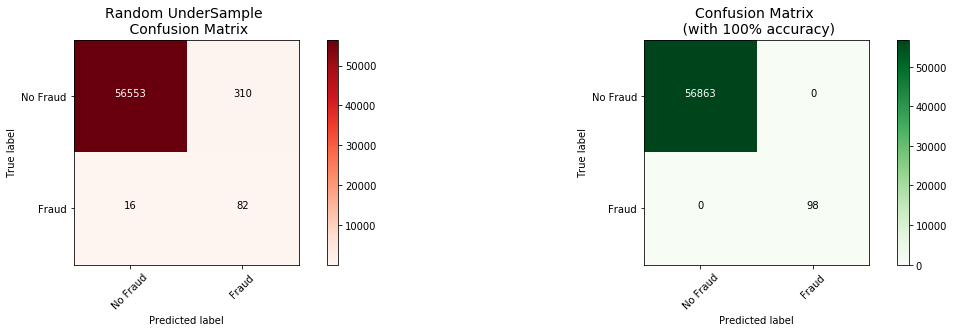

In [126]:
undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

### Keras || OverSampling (SMOTE):


In [127]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [128]:
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [129]:
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Train on 363923 samples, validate on 90981 samples
Epoch 1/20
 - 2s - loss: 0.1850 - acc: 0.9310 - val_loss: 0.1723 - val_acc: 0.9236
Epoch 2/20
 - 2s - loss: 0.1131 - acc: 0.9610 - val_loss: 0.2767 - val_acc: 0.8984
Epoch 3/20
 - 2s - loss: 0.1080 - acc: 0.9629 - val_loss: 0.1150 - val_acc: 0.9415
Epoch 4/20
 - 2s - loss: 0.1050 - acc: 0.9639 - val_loss: 0.2126 - val_acc: 0.9164
Epoch 5/20
 - 2s - loss: 0.1022 - acc: 0.9649 - val_loss: 0.2007 - val_acc: 0.9178
Epoch 6/20
 - 2s - loss: 0.1001 - acc: 0.9656 - val_loss: 0.1326 - val_acc: 0.9381
Epoch 7/20
 - 2s - loss: 0.0982 - acc: 0.9659 - val_loss: 0.2046 - val_acc: 0.9199
Epoch 8/20
 - 2s - loss: 0.0966 - acc: 0.9663 - val_loss: 0.1721 - val_acc: 0.9268
Epoch 9/20
 - 2s - loss: 0.0947 - acc: 0.9668 - val_loss: 0.1714 - val_acc: 0.9255
Epoch 10/20
 - 2s - loss: 0.0932 - acc: 0.9672 - val_loss: 0.1295 - val_acc: 0.9418
Epoch 11/20
 - 2s - loss: 0.0921 - acc: 0.9672 - val_loss: 0.1440 - val_acc: 0.9362
Epoch 12/20
 - 2s - loss: 0.0899 -

In [132]:
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [134]:
oversample_fraud_predictions = oversample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

Confusion matrix, without normalization
[[56130   733]
 [   13    85]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


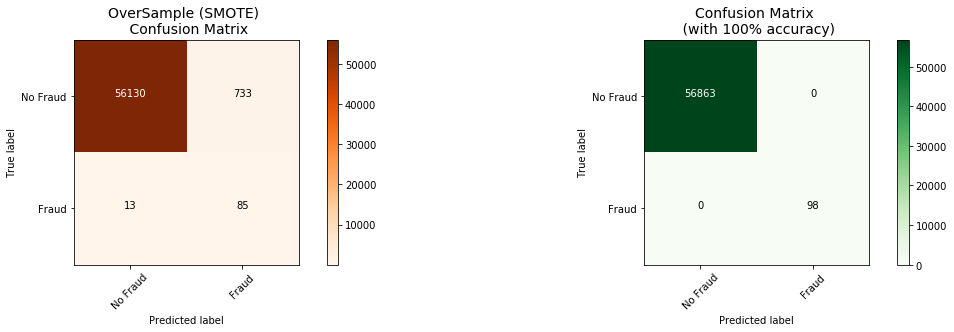

In [135]:
oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

# Kesimpulan:
Menerapkan SMOTE pada kumpulan data yang tidak seimbang membantu kami dengan ketidakseimbangan label kami (lebih tidak ada penipuan daripada transaksi penipuan). Namun demikian, saya masih harus menyatakan bahwa kadang-kadang jaringan saraf pada dataset oversampled memprediksi transaksi penipuan yang kurang tepat daripada model yang menggunakan dataset undersample. Namun, perlu diingat bahwa penghapusan outlier hanya diterapkan pada kumpulan data acak di bawah sampel dan bukan pada dataset oversampled. Selain itu, dalam data sampel kami, modeltidak dapat mendeteksi sejumlah besar kasus transaksi non-penipuan dengan benar dan sebaliknya, salah mengklasifikasikan transaksi non-penipuan tersebut sebagai kasus penipuan. Bayangkan orang-orang yang melakukan pembelian reguler diblokir kartunya karena alasan model kami mengklasifikasikan transaksi itu sebagai transaksi penipuan, ini akan menjadi kerugian besar bagi lembaga keuangan. Jumlah keluhan pelanggan dan ketidakpuasan pelanggan akan meningkat. Langkah selanjutnya dari analisis ini adalah melakukan penghapusan outlier pada dataset oversample kami dan melihat apakah akurasi dalam set pengujian meningkat.
